# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Number of time series per process
series_per_process = 3

# Length of an individual time series
T = 1_000

# Max ACF lags
n_lags = 20

## 1 Generate time series dataset

In [3]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([0.0], [0.0]),
    ArmaProcess.from_coeffs([-0.5], [0.0]),
    ArmaProcess.from_coeffs([0.0], [0.9]),
    ArmaProcess.from_coeffs([0.5], [0.5])    
]

In [4]:
n_processes = len(processes)
n_series = n_processes * series_per_process

# Generate the time series.
df = pd.DataFrame()
for i in range(n_series):
    df[f"TS_{i}"] = processes[i // series_per_process].generate_sample(T)

In [5]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,-0.043827,-0.826280,0.683483,1.126378,0.330117,0.471777,1.620504,-0.873697,-0.484840,-0.991417,0.947675,0.040851
1,0.539164,0.593476,-0.762610,-0.693404,1.135268,-0.270642,1.920630,-0.522359,-0.541645,-0.953269,1.966762,-0.740270
2,0.060522,0.418926,1.258128,-1.767529,-0.983530,1.375734,0.722809,0.467853,1.328587,0.009527,2.351921,-0.989327
3,0.406662,0.976188,-1.247996,0.030955,0.758374,0.220195,1.375226,0.629666,2.136797,-0.190677,2.193098,1.425103
4,1.371663,-0.546677,-0.230267,-0.027913,0.297518,0.104058,1.098652,0.521429,0.446927,-0.436830,-0.120881,1.427868
5,0.197502,-0.230801,-1.872970,-0.535180,1.612080,-0.063797,-0.893548,-1.406043,-1.706411,1.297696,1.669384,-0.833637
6,0.697054,0.028440,0.702254,1.583529,-1.577638,-1.817843,-1.858904,-1.327422,-0.594271,1.478866,1.929021,-1.242843
7,1.870021,-0.014295,0.418733,1.183170,0.820619,0.690550,-1.722090,-0.019949,0.773542,0.053058,0.225728,-0.046739
8,0.122142,-1.755034,-1.760588,-0.966891,-0.752537,-0.037821,-2.441242,-1.087712,-0.519744,-0.728488,0.612980,-0.601766
9,0.094986,0.121765,-1.010943,0.828341,1.108920,-1.275151,-0.880530,-0.292312,-1.378348,0.404529,-0.469134,-0.395345


In [6]:
def plot_df(df, lower, upper, process):
    n_rows = upper - lower
    fig, ax = plt.subplots(
        nrows=n_rows, ncols=1,
        sharex=True, sharey=False,
        figsize=(12, 2 * n_rows),
        tight_layout=True)
    fig.suptitle(f"TS {lower}-{upper-1}\n{process}")
    for i in range(n_rows):
        ts_idx = lower + i
        ax[i].plot(df.iloc[:, ts_idx])
        #ax[i].set_title(f"TS {ts_idx}")
    plt.show()

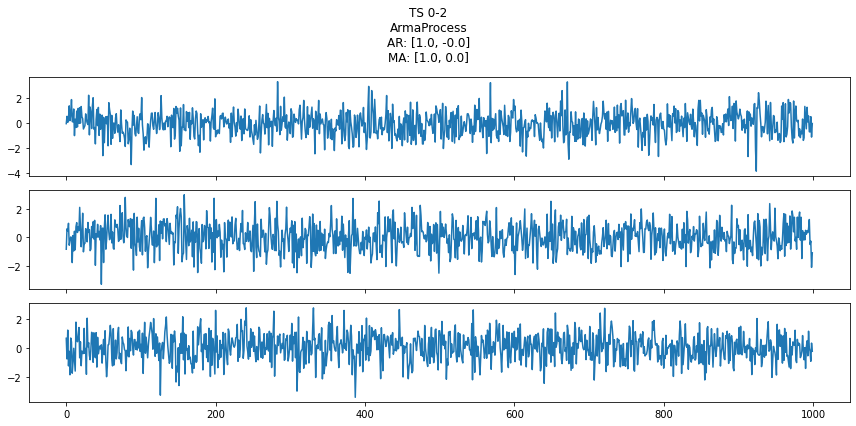

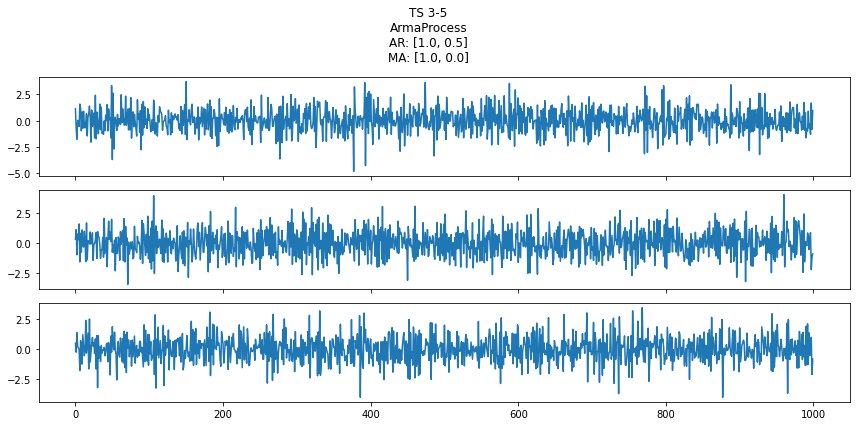

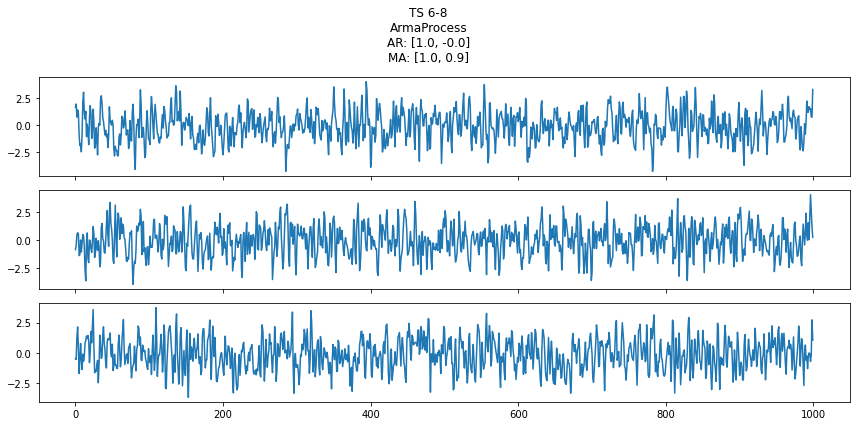

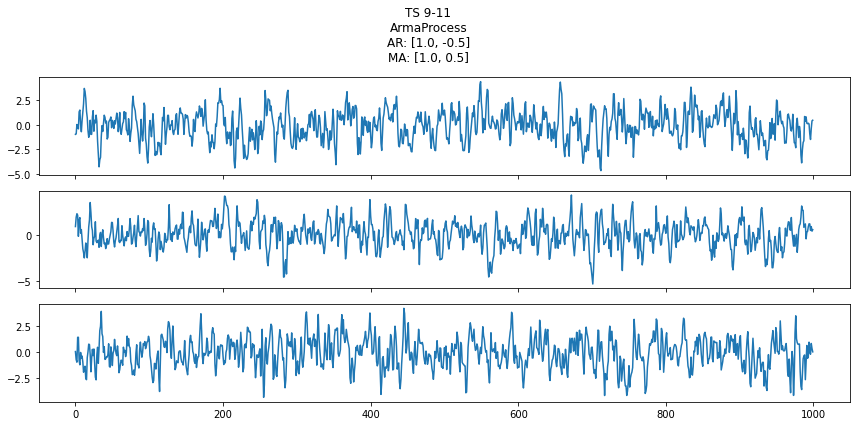

In [7]:
for i in range(n_processes):
    lower = i * series_per_process
    upper = lower + series_per_process
    plot_df(df, lower, upper, processes[i])

## 2 Estimate ACFs 

In [8]:
def acf(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

lag_arr = np.repeat(n_lags, df.shape[1])
acf_list = list(map(acf, df.transpose().to_numpy(), lag_arr))
acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns

In [9]:
acf_df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.017961,-0.011454,-0.021990,-0.469770,-0.478869,-0.484574,0.507251,0.468982,0.481040,0.728054,0.713453,0.690749
2,-0.019363,-0.006703,0.031992,0.251804,0.237661,0.197642,0.039065,-0.060769,-0.079559,0.400070,0.371590,0.316158
3,0.015660,-0.015791,-0.021827,-0.157339,-0.072322,-0.071519,0.032375,-0.044278,-0.095279,0.254385,0.181071,0.155213
4,0.041115,-0.011979,0.013639,0.061452,0.019114,0.032295,-0.004541,-0.042522,-0.000747,0.159196,0.047921,0.128026
5,0.025526,-0.003534,0.013797,-0.058425,0.036465,-0.033996,-0.035113,-0.066198,0.046444,0.071430,-0.010541,0.107489
6,0.009737,-0.021175,0.032109,0.081632,-0.013966,0.038573,-0.052914,-0.065547,-0.000397,0.026604,-0.032361,0.043187
7,0.025346,0.008474,-0.058580,-0.072740,0.015224,-0.022098,-0.066703,-0.026837,0.003986,0.007875,-0.057971,-0.016464
8,-0.016085,-0.006271,-0.029428,0.091532,0.046224,-0.022070,-0.074990,0.029472,0.062948,0.009928,-0.057470,-0.061360
9,0.059608,-0.019931,-0.012842,-0.051333,-0.065569,0.011948,-0.034215,0.021626,0.079205,0.029025,-0.032345,-0.077721


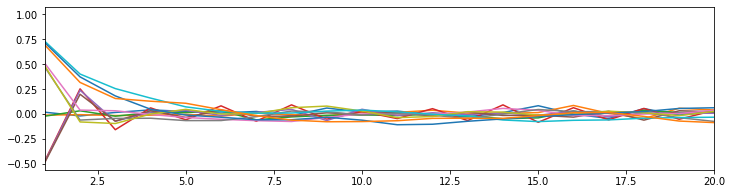

In [10]:
plt.figure(figsize=(12, 3))
plt.xlim((1, n_lags))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [11]:
n_clusters = n_processes
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([2, 2, 2, 0, 0, 0, 3, 3, 3, 1, 1, 1], dtype=int32)

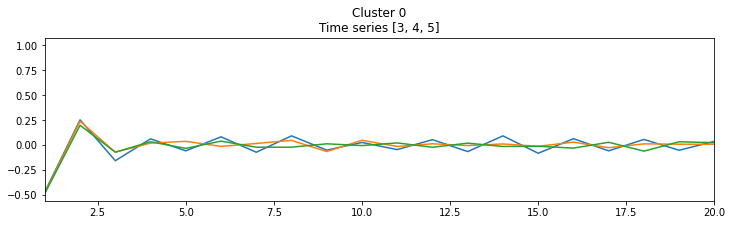

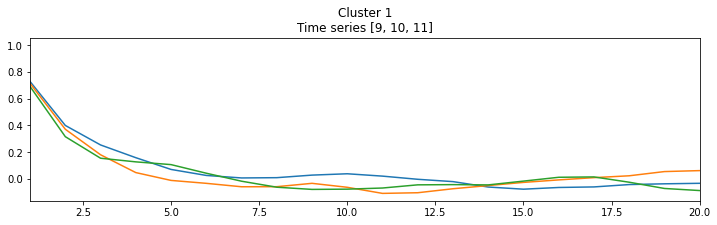

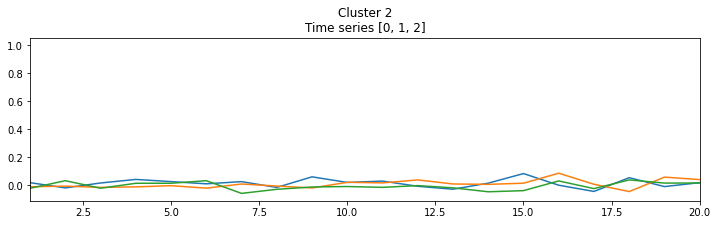

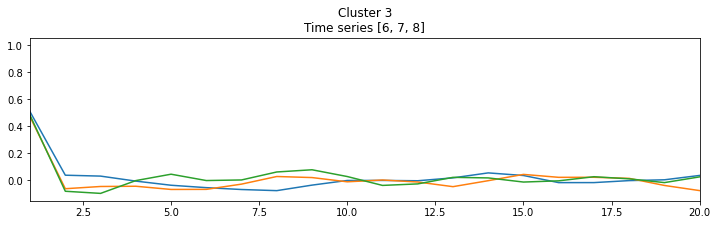

In [12]:
# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    ts = []

    # j ranges over the series ACFs
    for j in range(n_series):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
    
    plt.title(f"Cluster {i}\nTime series {ts}")
    plt.show()